## Import libraries

In [ ]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from keras.applications.densenet import preprocess_input
from keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D
from keras import layers, Model
from tensorflow.keras.models import Sequential
from keras.optimizers import Adam
import matplotlib
from matplotlib import pyplot as plt
import keras
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import numpy as np

## Data Visualization

Text(0.5, 1.0, 'Number of Training images per Class:')

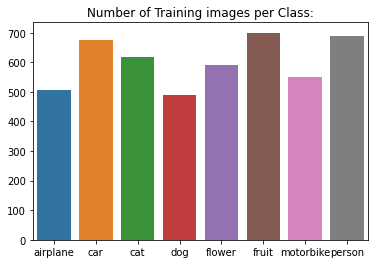

In [ ]:
train_data_dir = "/content/drive/My Drive/Thesis_Natural_Images/Dataset/Train"
val_data_dir = "/content/drive/My Drive/Thesis_Natural_Images/Dataset/Validation/"
test_data_dir = "/content/drive/My Drive/Thesis_Natural_Images/Dataset/Test/"
class_names = sorted(os.listdir(train_data_dir))

train_img_cat = []
val_img_cat = []
test_img_cat = []
for classes in class_names:
    train_folder = train_data_dir + '/' + classes
    train_img_cat.append(len(os.listdir(train_folder)))

for classes in class_names:
    val_folder = val_data_dir + '/' + classes
    val_img_cat.append(len(os.listdir(val_folder)))

for classes in class_names:
    test_folder = test_data_dir + '/' + classes
    test_img_cat.append(len(os.listdir(test_folder)))

sns.barplot(x=class_names, y=train_img_cat).set_title("Number of Training images per Class:")

Text(0.5, 1.0, 'Number of Validation images per Class:')

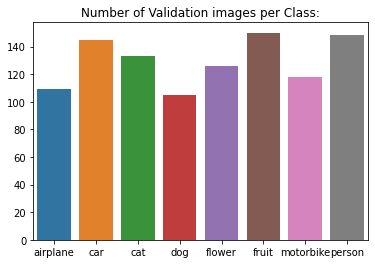

In [ ]:
sns.barplot(x=class_names, y=val_img_cat).set_title("Number of Validation images per Class:")

Text(0.5, 1.0, 'Number of Testing images per Class:')

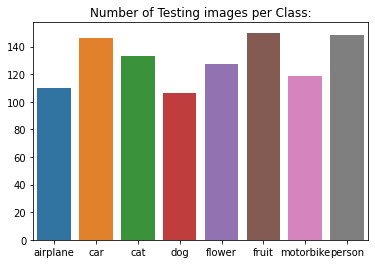

In [ ]:
sns.barplot(x=class_names, y=test_img_cat).set_title("Number of Testing images per Class:")

## Data Preprocessing
## Data Augmentation

In [ ]:
# pre processing using keras - flow from directory
# normalising
train_generator = ImageDataGenerator(rescale= 1.0/255,
                           rotation_range=10,
                           zoom_range=0.1,
                           width_shift_range=0.1,
                           height_shift_range=0.1,
                           horizontal_flip=False,
                           brightness_range=(0.9,1.1),
                           fill_mode='nearest'
                           )
val_generator = ImageDataGenerator(rescale=1.0/255)
test_generator = ImageDataGenerator(rescale=1.0/255)

train = train_generator.flow_from_directory('/content/drive/My Drive/Thesis_Natural_Images/Dataset/Train/',target_size=(256,256), class_mode='categorical', batch_size=64, shuffle=False)
val = val_generator.flow_from_directory('/content/drive/My Drive/Thesis_Natural_Images/Dataset/Validation/', target_size=(256,256), class_mode='categorical', batch_size=64, shuffle=False)
test = test_generator.flow_from_directory('/content/drive/My Drive/Thesis_Natural_Images/Dataset/Test/', target_size=(256,256), class_mode='categorical', batch_size=64, shuffle=False)

Found 4826 images belonging to 8 classes.
Found 1034 images belonging to 8 classes.
Found 1039 images belonging to 8 classes.


## Tranfer learning model
## InceptionResNetV2

In [ ]:
Inc_ResV2 = InceptionResNetV2(include_top=False,
                              weights='imagenet',
                              input_tensor=None,
                              input_shape=(256,256,3),
                              classes=8,
                              classifier_activation=None)

# make all layers not trainable
for layer in Inc_ResV2.layers:
  layer.trainable = False

In [ ]:
# get feature from pre-trained model
train_feature = Inc_ResV2.predict(train)
var_feature = Inc_ResV2.predict(val)

from keras.utils import to_categorical
# get classes
train_target = to_categorical(train.labels)
var_target = to_categorical(val.labels)

In [ ]:
var_target

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)

## Model Summary

In [ ]:
Inc_ResV2.summary()

Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_609 (Conv2D)             (None, 127, 127, 32) 864         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_618 (BatchN (None, 127, 127, 32) 96          conv2d_609[0][0]                 
__________________________________________________________________________________________________
activation_609 (Activation)     (None, 127, 127, 32) 0           batch_normalization_618[0][0]    
________________________________________________________________________________

## Fitting the Model

In [ ]:
IRNV2 = Sequential()
IRNV2.add(Flatten()) # input_shape = (8,8,512)
IRNV2.add(Dense(100, activation='relu'))
IRNV2.add(Dropout(0.5))
IRNV2.add(BatchNormalization())
IRNV2.add(Dense(8, activation='softmax'))

# compile the model
IRNV2.compile(optimizer='adam', metrics=['accuracy'], loss='categorical_crossentropy')

# train model using features generated from VGG16 model
result = IRNV2.fit(train_feature, train_target, epochs=5, steps_per_epoch=20, validation_data=(var_feature, var_target))

Epoch 1/5
20/20 [==============================] - 3s 171ms/step - loss: 0.2903 - accuracy: 0.9300 - val_loss: 0.0170 - val_accuracy: 0.9971
Epoch 2/5
20/20 [==============================] - 3s 164ms/step - loss: 0.0688 - accuracy: 0.9925 - val_loss: 0.0106 - val_accuracy: 0.9981
Epoch 3/5
20/20 [==============================] - 3s 164ms/step - loss: 0.0457 - accuracy: 0.9963 - val_loss: 0.0094 - val_accuracy: 0.9971
Epoch 4/5
20/20 [==============================] - 3s 166ms/step - loss: 0.0311 - accuracy: 0.9981 - val_loss: 0.0095 - val_accuracy: 0.9981
Epoch 5/5
20/20 [==============================] - 3s 162ms/step - loss: 0.0236 - accuracy: 0.9985 - val_loss: 0.0090 - val_accuracy: 0.9971


## Testing

In [ ]:
test_feature = Inc_ResV2.predict(test)
test_classes = to_categorical(test.labels)

In [ ]:
IRNV2.evaluate(test_feature, test_classes )

33/33 [==============================] - 0s 10ms/step - loss: 0.0076 - accuracy: 0.9971


[0.007594679947942495, 0.9971126317977905]

## Model Evaluation

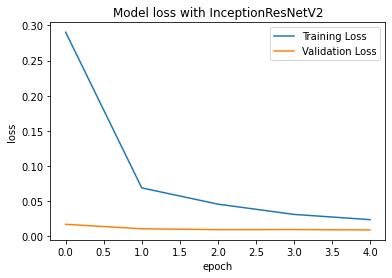

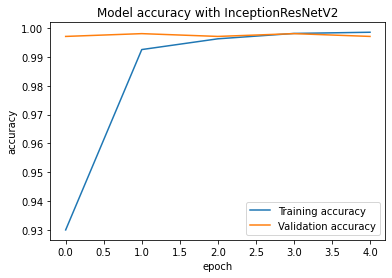

In [ ]:
# Plot.py

plt.plot(result.history['loss'], label='Training Loss')
plt.plot(result.history['val_loss'], label='Validation Loss')
plt.title('Model loss with InceptionResNetV2')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

plt.plot(result.history['accuracy'], label='Training accuracy')
plt.plot(result.history['val_accuracy'], label='Validation accuracy')
plt.title('Model accuracy with InceptionResNetV2')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

## Confusion Matrix

In [ ]:
import itertools
import numpy as np


def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
#Confution Matrix and Classification Report

Y_pred = IRNV2.predict(test_feature, 32)
y_pred = np.argmax(Y_pred, axis=1)

In [ ]:
cm = confusion_matrix(test.classes, y_pred)
cm_plot_labels = class_names
print(cm_plot_labels)

['airplane', 'car', 'cat', 'dog', 'flower', 'fruit', 'motorbike', 'person']


Confusion matrix, without normalization
[[110   0   0   0   0   0   0   0]
 [  0 146   0   0   0   0   0   0]
 [  0   0 133   0   0   0   0   0]
 [  0   0   0 106   0   0   0   0]
 [  0   0   0   2 124   1   0   0]
 [  0   0   0   0   0 150   0   0]
 [  0   0   0   0   0   0 119   0]
 [  0   0   0   0   0   0   0 148]]
None


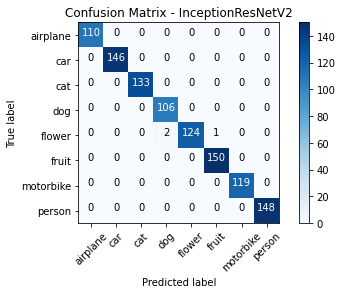

In [ ]:
print(plot_confusion_matrix(cm, classes = cm_plot_labels, title='Confusion Matrix - InceptionResNetV2', normalize=False))

## Classification Report

In [ ]:
print('Classification Report for InceptionResNetV2')
print(classification_report(test.classes, y_pred, target_names=class_names))

Classification Report for InceptionResNetV2
              precision    recall  f1-score   support

    airplane       1.00      1.00      1.00       110
         car       1.00      1.00      1.00       146
         cat       1.00      1.00      1.00       133
         dog       0.98      1.00      0.99       106
      flower       1.00      0.98      0.99       127
       fruit       0.99      1.00      1.00       150
   motorbike       1.00      1.00      1.00       119
      person       1.00      1.00      1.00       148

    accuracy                           1.00      1039
   macro avg       1.00      1.00      1.00      1039
weighted avg       1.00      1.00      1.00      1039

